# Assignment 3 — Fine-tuning a BERT-style model for Sentiment Classification

This notebook completes the required tasks:
- Literature notes (history + key papers)
- Task + dataset selection (binary sentiment classification on IMDB)
- Preprocessing (cleaning + tokenization + proper train/validation/test split)
- Baselines (TF‑IDF + Logistic Regression; and pretrained BERT “no fine-tuning”)
- Fine-tuning BERT with Hugging Face Transformers
- Evaluation (accuracy, precision, recall, F1; confusion matrix + classification report)
- Comparison table + saving + simple inference demo


## 1) Literature notes

**BERT (Devlin et al., 2018)**  
- Transformer encoder pre-trained with Masked Language Modeling (MLM) + Next Sentence Prediction (NSP).  
- Fine-tuning adds a small classifier head and trains the whole network end-to-end for downstream tasks.

**RoBERTa (Liu et al., 2019)**  
- Improves BERT by removing NSP, training longer on more data, and using dynamic masking.  
- Often yields stronger classification performance than BERT with similar architecture.

**Why Transformers help for sentiment**  
- Contextual embeddings capture meaning dependent on surrounding words (e.g., negation like “not good”).  
- Handles long-range dependencies better than bag-of-words baselines.


## 2) Task + Dataset

**Task:** Binary sentiment classification (positive vs negative).  
**Dataset:** IMDB (Hugging Face imdb) — large, balanced movie reviews with standard train/test splits.  
We create a **validation split** from train and keep **test** only for final evaluation.


In [1]:
# Install dependencies (Colab/clean env only)
# If you're running locally and already have these, you can skip.
!pip -q install -U datasets transformers accelerate scikit-learn matplotlib

import warnings
warnings.filterwarnings("ignore")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 22.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0;

In [2]:
# 1) Imports + reproducibility
import os
import random
import numpy as np
import pandas as pd
import torch

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed,
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
# 2) Load dataset
DATASET_NAME = "imdb"
raw = load_dataset(DATASET_NAME)
raw


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [4]:
# 3) Create a validation split (keep test untouched for final evaluation)
# IMDB provides train/test; we split train -> train/validation.
dataset = raw
if "validation" not in dataset:
    split = dataset["train"].train_test_split(test_size=0.1, seed=SEED)
    dataset = {
        "train": split["train"],
        "validation": split["test"],
        "test": dataset["test"],
    }

print("Train:", len(dataset["train"]), "Val:", len(dataset["validation"]), "Test:", len(dataset["test"]))
print(dataset["train"].features)


Train: 22500 Val: 2500 Test: 25000
{'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}


In [5]:
# 4) Basic cleaning (lightweight; avoids changing meaning too much)
def clean_text(x: str) -> str:
    if x is None:
        return ""
    x = str(x).strip()
    x = " ".join(x.split())  # collapse whitespace
    return x

for split_name in ["train", "validation", "test"]:
    dataset[split_name] = dataset[split_name].map(lambda e: {"text": clean_text(e["text"])})

dataset["train"][0]


Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

{'text': "With these people faking so many shots, using old footage, and gassing animals to get them out, not to mention that some of the scenes were filmed on a created set with actors, what's to believe? Old film of countries is nice, but the animal abuse and degradation of natives is painful to watch in these films. I know, racism is OK in these old films, but there is more to that to make this couple lose credibility. Portrayed as fliers, they never flew their planes, Martin Johnson was an ex-vaudevillian, used friends like Jack London for financial gain while stiffing them of royalties, denying his wife's apparent depression, using her as a cute prop, all this makes these films unbearable. They were by no means the first to travel to these lands, or the first to write about them. He was OK as a filmmaker and photographer, but that's about it.",
 'label': 0}

In [6]:
# 5) Baseline model: TF-IDF + Logistic Regression
X_train = dataset["train"]["text"]
y_train = np.array(dataset["train"]["label"])

X_val = dataset["validation"]["text"]
y_val = np.array(dataset["validation"]["label"])

X_test = dataset["test"]["text"]
y_test = np.array(dataset["test"]["label"])

tfidf = TfidfVectorizer(max_features=50_000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

val_pred_lr = lr.predict(X_val_tfidf)
test_pred_lr = lr.predict(X_test_tfidf)

def prf(y_true, y_pred):
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    return acc, p, r, f1

baseline_val = prf(y_val, val_pred_lr)
baseline_test = prf(y_test, test_pred_lr)

print("Baseline (TF‑IDF + LR) — VALIDATION [acc, prec, rec, f1]:", baseline_val)
print("Baseline (TF‑IDF + LR) — TEST        [acc, prec, rec, f1]:", baseline_test)


Baseline (TF‑IDF + LR) — VALIDATION [acc, prec, rec, f1]: (0.9032, 0.9076305220883534, 0.8989657915672236, 0.903277378097522)
Baseline (TF‑IDF + LR) — TEST        [acc, prec, rec, f1]: (0.89268, 0.8906486271388778, 0.89528, 0.8929583083981648)


In [7]:
# 6) Tokenize with BERT tokenizer
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

MAX_LEN = 256

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=MAX_LEN)

tokenized = {
    "train": dataset["train"].map(tokenize_function, batched=True, remove_columns=["text"]),
    "validation": dataset["validation"].map(tokenize_function, batched=True, remove_columns=["text"]),
    "test": dataset["test"].map(tokenize_function, batched=True, remove_columns=["text"]),
}

tokenized["train"][0].keys()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

dict_keys(['label', 'input_ids', 'token_type_ids', 'attention_mask'])

In [8]:
# 7) Metrics for evaluation (accuracy, precision, recall, F1)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [9]:
# 8) Build model + TrainingArguments (uses eval_strategy — important for newer transformers versions)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

training_args = TrainingArguments(
    output_dir="bert-imdb",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,

    # Newer versions commonly use eval_strategy (not evaluation_strategy)
    eval_strategy="epoch",
    save_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    logging_steps=50,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],  # VALIDATION during training
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# 9) Baseline 2: "Pretrained BERT (no fine-tuning)" on validation
# (Classifier head is randomly initialized for this task, so performance is near chance)
pretrained_val_metrics = trainer.evaluate(eval_dataset=tokenized["validation"])
print("Pretrained BERT (no fine-tuning) — VALIDATION:", pretrained_val_metrics)


Pretrained BERT (no fine-tuning) — VALIDATION: {'eval_loss': 0.6916947364807129, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': 0.5052, 'eval_precision': 0.5043066322136089, 'eval_recall': 0.9315831344470963, 'eval_f1': 0.6543727298127968, 'eval_runtime': 32.8192, 'eval_samples_per_second': 76.175, 'eval_steps_per_second': 4.784}


In [11]:
# 10) Fine-tune BERT
train_result = trainer.train()
train_result


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.264400,0.244441,0.002700,0.909600,0.921504,0.896579,0.908871
2,0.121500,0.292136,0.002700,0.914000,0.915470,0.913286,0.914377


TrainOutput(global_step=2814, training_loss=0.21518435779834522, metrics={'train_runtime': 2028.4339, 'train_samples_per_second': 22.185, 'train_steps_per_second': 1.387, 'total_flos': 5919891856733760.0, 'train_loss': 0.21518435779834522, 'epoch': 2.0})

In [12]:
# 11) Final evaluation on TEST (only after training is finished)
bert_test_metrics = trainer.evaluate(eval_dataset=tokenized["test"])
print("Fine-tuned BERT — TEST:", bert_test_metrics)


Fine-tuned BERT — TEST: {'eval_loss': 0.25802138447761536, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': 0.9206, 'eval_precision': 0.915974365060527, 'eval_recall': 0.92616, 'eval_f1': 0.9210390230319424, 'eval_runtime': 343.4425, 'eval_samples_per_second': 72.792, 'eval_steps_per_second': 4.551, 'epoch': 2.0}


In [13]:
# 12) Detailed reports (classification report + confusion matrix) on TEST
pred_out = trainer.predict(tokenized["test"])
y_pred_bert = np.argmax(pred_out.predictions, axis=-1)

print("Classification report (BERT, TEST):")
print(classification_report(y_test, y_pred_bert, digits=4))

print("Confusion matrix (BERT, TEST):")
print(confusion_matrix(y_test, y_pred_bert))


Classification report (BERT, TEST):
              precision    recall  f1-score   support

           0     0.9253    0.9150    0.9202     12500
           1     0.9160    0.9262    0.9210     12500

    accuracy                         0.9206     25000
   macro avg     0.9207    0.9206    0.9206     25000
weighted avg     0.9207    0.9206    0.9206     25000

Confusion matrix (BERT, TEST):
[[11438  1062]
 [  923 11577]]


,Model,Accuracy,Precision,Recall,F1
0,Baseline TF‑IDF + LogisticRegression (TEST),0.89268,0.890649,0.895280,0.892958
1,Pretrained BERT (no fine‑tuning) (VAL),0.50520,0.504307,0.931583,0.654373
2,Fine‑tuned BERT (TEST),0.92060,0.915974,0.926160,0.921039


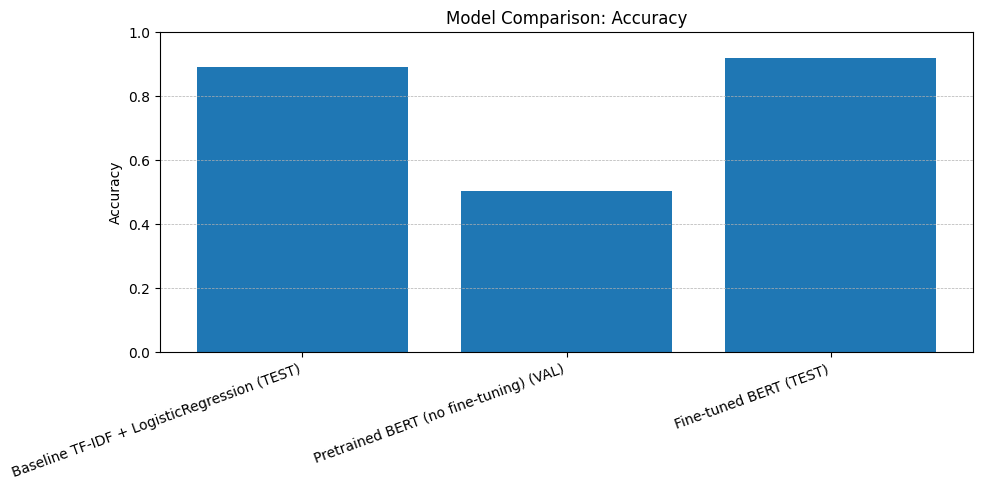

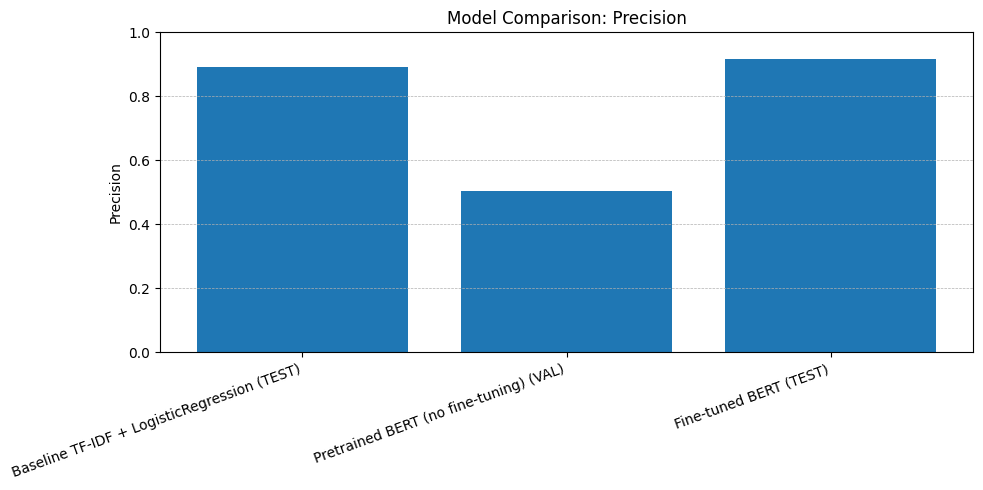

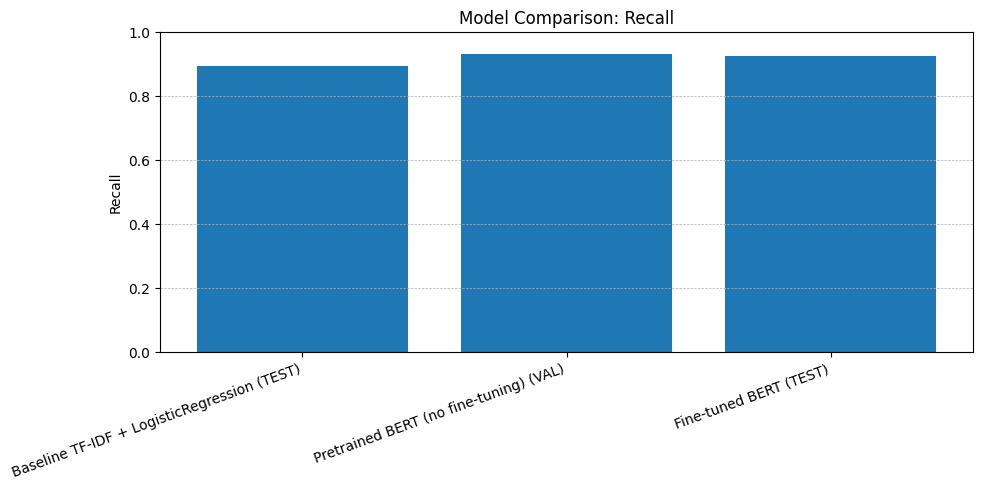

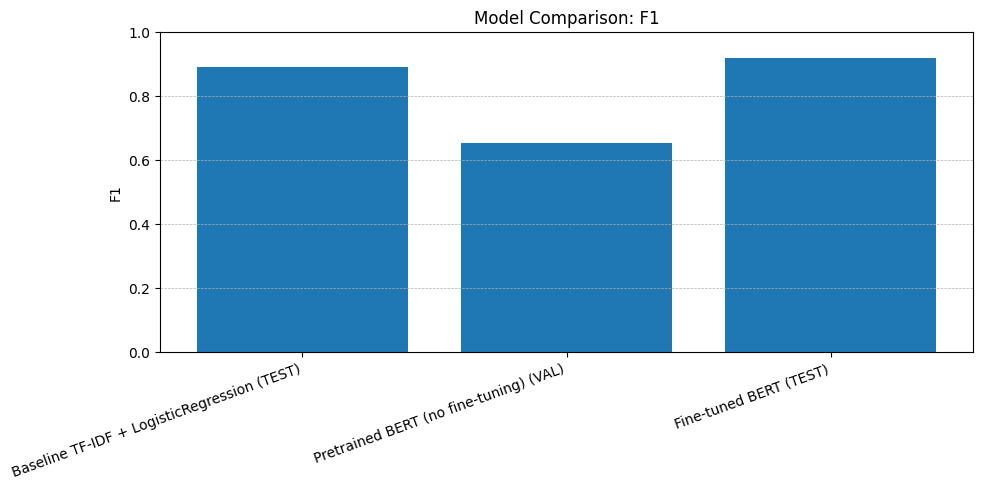

from matplotlib import pyplot as plt
results['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['F1'].plot(kind='hist', bins=20, title='F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='Recall', y='F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['F1'].plot(kind='line', figsize=(8, 4), title='F1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='Precision', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='Recall', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='F1', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [14]:
# 13) Comparison table (Baseline vs Pretrained BERT vs Fine-tuned BERT)
# Baseline LR: use TEST numbers computed earlier.
# Pretrained BERT: use validation metrics (since we did not evaluate pretrained on test to avoid peeking)
# Fine-tuned BERT: use TEST metrics from trainer.

results = pd.DataFrame([
    {
        "Model": "Baseline TF‑IDF + LogisticRegression (TEST)",
        "Accuracy": baseline_test[0],
        "Precision": baseline_test[1],
        "Recall": baseline_test[2],
        "F1": baseline_test[3],
    },
    {
        "Model": "Pretrained BERT (no fine‑tuning) (VAL)",
        "Accuracy": pretrained_val_metrics["eval_accuracy"],
        "Precision": pretrained_val_metrics["eval_precision"],
        "Recall": pretrained_val_metrics["eval_recall"],
        "F1": pretrained_val_metrics["eval_f1"],
    },
    {
        "Model": "Fine‑tuned BERT (TEST)",
        "Accuracy": bert_test_metrics["eval_accuracy"],
        "Precision": bert_test_metrics["eval_precision"],
        "Recall": bert_test_metrics["eval_recall"],
        "F1": bert_test_metrics["eval_f1"],
    },
])

results


import matplotlib.pyplot as plt

# Show table
display(results)

# Prepare data
metrics = ["Accuracy", "Precision", "Recall", "F1"]
x = np.arange(len(results["Model"]))
labels = results["Model"].tolist()

# Plot one chart per metric (clear + readable)
for m in metrics:
    plt.figure(figsize=(10, 5))
    plt.bar(x, results[m].values)
    plt.xticks(x, labels, rotation=20, ha="right")
    plt.ylim(0, 1)
    plt.ylabel(m)
    plt.title(f"Model Comparison: {m}")
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [15]:
# 14) Save fine-tuned model + tokenizer
SAVE_DIR = "./saved_bert_sentiment"
os.makedirs(SAVE_DIR, exist_ok=True)
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print("Saved to:", SAVE_DIR)


Saved to: ./saved_bert_sentiment


In [16]:
# 15) Simple inference demo
id2label = {0: "NEGATIVE", 1: "POSITIVE"}

def predict_sentiment(text: str):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy().ravel()
    pred = int(np.argmax(probs))
    return {"label": id2label[pred], "prob_negative": float(probs[0]), "prob_positive": float(probs[1])}

predict_sentiment("This movie was surprisingly good. The acting and plot were great!")


{'label': 'POSITIVE',
 'prob_negative': 0.0037226425483822823,
 'prob_positive': 0.996277391910553}